# Data Preprocessing

## Import the libraries

In [1]:
# Import statements
import numpy as np 
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import warnings
import itertools
import statsmodels.api as sm
import seaborn as sns
import math
from pylab import rcParams
from sklearn.preprocessing import MinMaxScaler

#Jupyter Notebook Specific
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

## Importing the dataset

In [2]:
import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
cos_client = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='FjZhasNLrqr-RsG6w1hZAMFdQtk_dmkoyYs7dqe4jwWe',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.private.us.cloud-object-storage.appdomain.cloud')

bucket = 'crudeoilpricepredictor-donotdelete-pr-o7jpbdylwbsibg'
object_key = 'Crude Oil Prices Daily.csv'

body = cos_client.get_object(Bucket=bucket,Key=object_key)['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df = pd.read_csv(body)
df.head()


,Date,Price
0,2-Jan-86,25.56
1,3-Jan-86,26.00
2,6-Jan-86,26.53
3,7-Jan-86,25.85
4,8-Jan-86,25.87


In [3]:
df['Date'] = pd.to_datetime(df['Date'])

## Handling missing data

In [4]:
df.isnull().any()

Date     False
Price    False
dtype: bool

In [5]:
df.dropna(axis=0,inplace=True)

In [6]:
data_oil = df.reset_index()['Price']

In [7]:
len(data_oil)

9281

## Data visualization

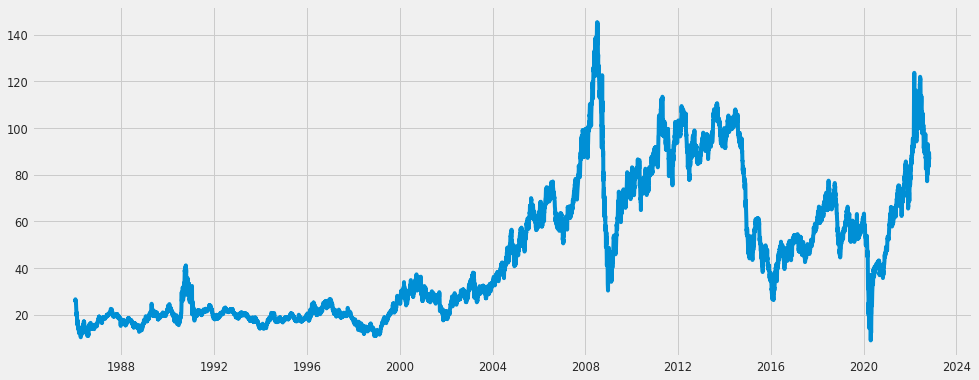

In [8]:
plt_1 = plt.figure(figsize=(15, 6))
time = pd.to_datetime(df['Date'])
data = list(df['Price'])
copdata = pd.Series(data, time)
plt.plot(copdata)

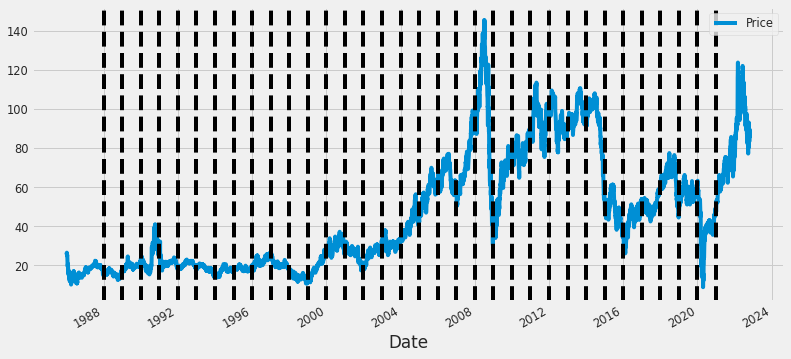

In [9]:
#observe for any seasonal patterns
ax = df.plot(x='Date', y='Price', figsize=(12,6))
xcoords = ['1988-01-01','1989-01-01','1990-01-01','1991-01-01','1992-01-01','1993-01-01','1994-01-01',
           '1995-01-01','1996-01-01','1997-01-01','1998-01-01','1999-01-01','2000-01-01','2001-01-01',
           '2002-01-01','2003-01-01','2004-01-01','2005-01-01','2006-01-01','2007-01-01','2008-01-01',
           '2009-01-01','2010-01-01','2011-01-01','2012-01-01','2013-01-01','2014-01-01','2015-01-01',
           '2016-01-01','2017-01-01', '2018-01-01', '2019-01-01', '2020-01-01','2021-01-01']
for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle='--')

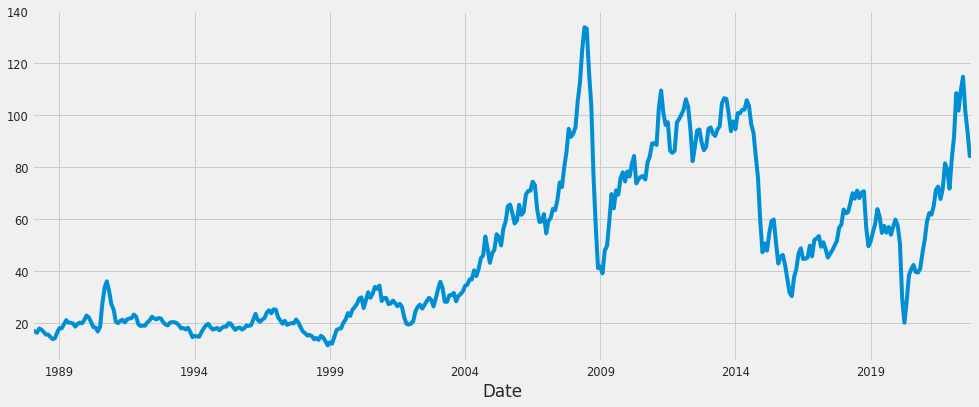

In [10]:
#Decompose the plot
df1 = df
df1 = df1.sort_values('Date')
df1 = df1.groupby('Date')['Price'].sum().reset_index()
df1.set_index('Date', inplace=True)
df1=df1.loc[datetime.date(year=1988,month=1,day=1):]

q = df1['Price'].resample('MS').mean()
q.plot(figsize=(15, 6))
plt.show()

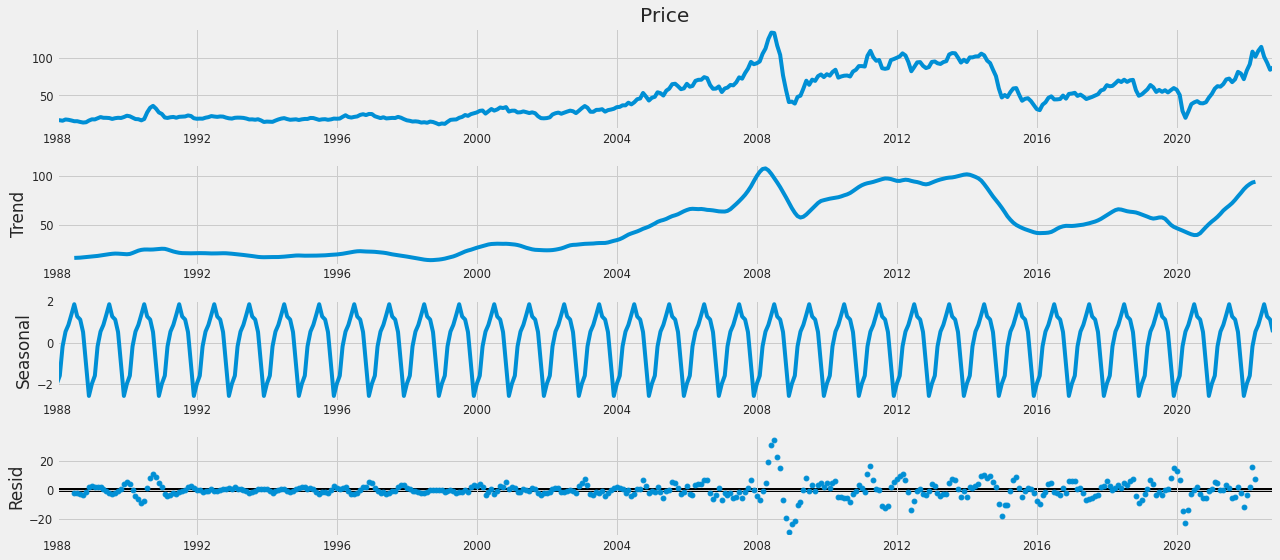

In [11]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(q, model='additive')
fig = decomposition.plot()
plt.show()

## Feature Scaling


In [12]:
sc = MinMaxScaler(feature_range = (0, 1))
data_oil = sc.fit_transform(np.array(data_oil).reshape(-1,1))

In [13]:
len(data_oil)

9281

## Train Test Split

In [14]:
train_size = int(len(data_oil) * 0.65)
test_size = len(data_oil) - train_size
train, test = data_oil[0:train_size, :], data_oil[train_size:len(data_oil), :]

In [15]:
len(test)

3249

## Creating Window

In [16]:
def create_dataset(_data_set, _look_back=1):
    data_x, data_y = [], []
    for i in range(len(_data_set) - _look_back - 1):
        a = _data_set[i:(i + _look_back), 0]
        data_x.append(a)
        data_y.append(_data_set[i + _look_back, 0])
    return np.array(data_x), np.array(data_y)


time_step = 10
X_train , Y_train = create_dataset(train,time_step)
X_test , Y_test = create_dataset(test,time_step)

X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [17]:
X_train.shape

(6021, 10, 1)

# **Model Building**

## Import the Model building libraries

In [18]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.metrics import mean_squared_error
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

## Model

In [19]:
regressor = Sequential()
regressor.add(LSTM(units = 60, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.1))

regressor.add(LSTM(units = 60, return_sequences = True))
regressor.add(Dropout(0.1))

regressor.add(LSTM(units = 60))
regressor.add(Dropout(0.1))

regressor.add(Dense(units = 1))

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
# early_stopping = EarlyStopping(monitor='val_loss',patience=20)
history =regressor.fit(X_train, Y_train, epochs = 20, batch_size = 64,validation_data=(X_test, Y_test),verbose=1)
# history =regressor.fit(X_train, Y_train, epochs = 100, batch_size = 64,validation_data=(X_test, Y_test), callbacks=[early_stopping],shuffle=False,verbose=1)

Epoch 1/20
95/95 [==============================] - 8s 44ms/step - loss: 0.0033 - val_loss: 0.0014
Epoch 2/20
95/95 [==============================] - 3s 33ms/step - loss: 4.9335e-04 - val_loss: 6.3755e-04
Epoch 3/20
95/95 [==============================] - 3s 29ms/step - loss: 4.7849e-04 - val_loss: 0.0018
Epoch 4/20
95/95 [==============================] - 3s 32ms/step - loss: 5.4275e-04 - val_loss: 0.0017
Epoch 5/20
95/95 [==============================] - 3s 34ms/step - loss: 4.7479e-04 - val_loss: 0.0014
Epoch 6/20
95/95 [==============================] - 4s 37ms/step - loss: 4.3976e-04 - val_loss: 6.0805e-04
Epoch 7/20
95/95 [==============================] - 3s 34ms/step - loss: 4.3700e-04 - val_loss: 0.0012
Epoch 8/20
95/95 [==============================] - 4s 42ms/step - loss: 4.6301e-04 - val_loss: 0.0034
Epoch 9/20
95/95 [==============================] - 4s 46ms/step - loss: 4.9073e-04 - val_loss: 0.0013
Epoch 10/20
95/95 [==============================] - 4s 40ms/step - l

## Train the model

In [20]:
train_predict = regressor.predict(X_train)
test_predict = regressor.predict(X_test)

In [21]:
# invert predictions
train_predict = sc.inverse_transform(train_predict)
Y_train = sc.inverse_transform([Y_train])
test_predict = sc.inverse_transform(test_predict)
Y_test = sc.inverse_transform([Y_test])

## Model evaluation

Train Mean Absolute Error: 1.3663797223696652
Train Root Mean Squared Error: 2.007354212032718
Test Mean Absolute Error: 2.4813965159717206
Test Root Mean Squared Error: 3.1592578672259126


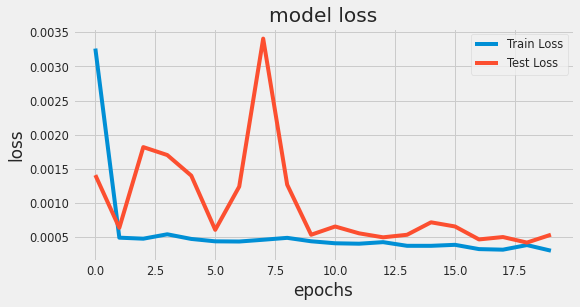

In [22]:
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

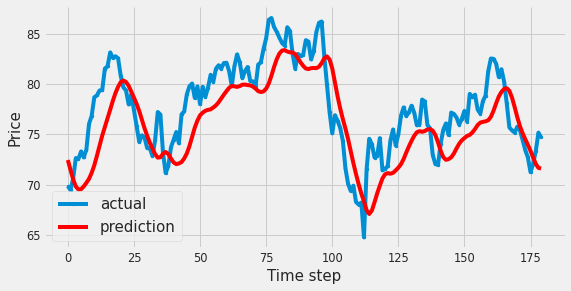

In [23]:
aa=[x for x in range(180)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:180], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:180], 'r', label="prediction")
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Price', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

## Save the model

In [24]:
regressor.save("crude_oil.h5")

In [25]:
!tar -zcvf crude_oil_prediction.tgz crude_oil.h5

crude_oil.h5


## IBM WATSON Deployment

In [26]:
!pip install ibm_watson_machine_learning
!pip install watson-machine-learning-client

     |████████████████████████████████| 538 kB 10.2 MB/s eta 0:00:01


In [27]:
from ibm_watson_machine_learning import APIClient
wml_credentials = {
                    "url" : "https://us-south.ml.cloud.ibm.com",
                    "apikey" : "z-vGDkWG1pITk_FDEyS7oqlXAwjzinebzOESecqxe8iw"
                }
client = APIClient(wml_credentials)

In [28]:
def guid_from_space_name(client,space_name):
    space = client.spaces.get_details()
    return(next(item for item in space['resources'] if item['entity']["name"] == space_name)['metadata']['id'])

In [29]:
space_uid = guid_from_space_name(client,'models')
print("Space - {}".format(space_uid))

Space - 8b7dce31-65d1-4adf-ac5b-5f120101c023


In [30]:
client.set.default_space(space_uid)

'SUCCESS'

In [31]:
client.software_specifications.list()

-----------------------------  ------------------------------------  ----
NAME                           ASSET_ID                              TYPE
default_py3.6                  0062b8c9-8b7d-44a0-a9b9-46c416adcbd9  base
kernel-spark3.2-scala2.12      020d69ce-7ac1-5e68-ac1a-31189867356a  base
pytorch-onnx_1.3-py3.7-edt     069ea134-3346-5748-b513-49120e15d288  base
scikit-learn_0.20-py3.6        09c5a1d0-9c1e-4473-a344-eb7b665ff687  base
spark-mllib_3.0-scala_2.12     09f4cff0-90a7-5899-b9ed-1ef348aebdee  base
pytorch-onnx_rt22.1-py3.9      0b848dd4-e681-5599-be41-b5f6fccc6471  base
ai-function_0.1-py3.6          0cdb0f1e-5376-4f4d-92dd-da3b69aa9bda  base
shiny-r3.6                     0e6e79df-875e-4f24-8ae9-62dcc2148306  base
tensorflow_2.4-py3.7-horovod   1092590a-307d-563d-9b62-4eb7d64b3f22  base
pytorch_1.1-py3.6              10ac12d6-6b30-4ccd-8392-3e922c096a92  base
tensorflow_1.15-py3.6-ddl      111e41b3-de2d-5422-a4d6-bf776828c4b7  base
autoai-kb_rt22.2-py3.10        125b6d9

In [32]:
software_spec_uid = client.software_specifications.get_uid_by_name("tensorflow_rt22.1-py3.9")
software_spec_uid

'acd9c798-6974-5d2f-a657-ce06e986df4d'

In [33]:
model_details = client.repository.store_model(model = "crude_oil_prediction.tgz",meta_props={
    client.repository.ModelMetaNames.NAME:"CrudeOil Price Prediction",
    client.repository.ModelMetaNames.TYPE:"tensorflow_2.7",
    client.repository.ModelMetaNames.SOFTWARE_SPEC_UID:software_spec_uid
})

model_id = client.repository.get_model_id(model_details)

In [35]:
model_id = client.repository.get_model_id(model_details)
model_id


'ff79b193-e9f8-4f97-b04e-3bd89acc6b3c'

In [37]:
client.repository.download(model_id,'B2_IBM_model.tar.gb')

Successfully saved model content to file: 'B2_IBM_model.tar.gb'


'/home/wsuser/work/B2_IBM_model.tar.gb'

## Test the model

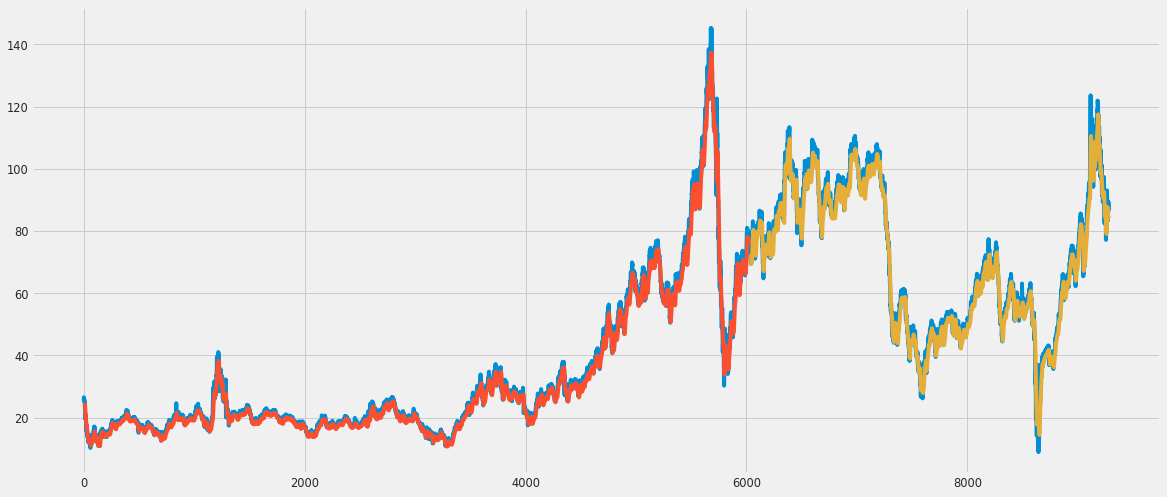

In [38]:
#test the model
look_back = 10
trainPredictPlot = np.empty_like(data_oil)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back,:] = train_predict

testPredictPlot = np.empty_like(data_oil)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(data_oil)-1,:] = test_predict

plt.plot(sc.inverse_transform(data_oil))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [39]:
len(test)

3249

In [40]:
x_input = test[3239:].reshape(1,-1)
x_input.shape

(1, 10)

In [41]:
temp_input = list(x_input[0])
temp_list = temp_input[0].tolist()

In [42]:
temp_input

[0.545307917888563,
 0.5651759530791789,
 0.5653225806451613,
 0.5612903225806452,
 0.5660557184750733,
 0.5719941348973607,
 0.5900293255131964,
 0.5876099706744868,
 0.5787390029325512,
 0.5691348973607039]

In [43]:
lst_output = []
n_steps = 10
i = 0

while(i<10):
  if(len(temp_input) > 10):
    x_input = np.array(temp_input[1:])
    print("{} day input {}".format(i,x_input),end="\n")
    x_input = x_input.reshape(1,-1)
    x_input = x_input.reshape((1,n_steps,1))

    yhat = regressor.predict(x_input,verbose=0)
    print("{} day output {}".format(i,yhat),end="\n")
    temp_input.extend(yhat[0].tolist())
    temp_input = temp_input[1:]
    print("------------------------",end="\n")
    lst_output.extend(yhat.tolist())
    i = i+1
  else:
    x_input = x_input.reshape((1,n_steps,1))
    yhat = regressor.predict(x_input,verbose=0)
    print("{} day output {}".format(i,yhat),end="\n")
    temp_input.extend(yhat[0].tolist())
    lst_output.extend(yhat.tolist())
    i = i+1

0 day output [[0.56284255]]
1 day input [0.56517595 0.56532258 0.56129032 0.56605572 0.57199413 0.59002933
 0.58760997 0.578739   0.5691349  0.56284255]
1 day output [[0.5625979]]
------------------------
2 day input [0.56532258 0.56129032 0.56605572 0.57199413 0.59002933 0.58760997
 0.578739   0.5691349  0.56284255 0.56259787]
2 day output [[0.5607151]]
------------------------
3 day input [0.56129032 0.56605572 0.57199413 0.59002933 0.58760997 0.578739
 0.5691349  0.56284255 0.56259787 0.56071508]
3 day output [[0.558114]]
------------------------
4 day input [0.56605572 0.57199413 0.59002933 0.58760997 0.578739   0.5691349
 0.56284255 0.56259787 0.56071508 0.55811399]
4 day output [[0.5552214]]
------------------------
5 day input [0.57199413 0.59002933 0.58760997 0.578739   0.5691349  0.56284255
 0.56259787 0.56071508 0.55811399 0.55522138]
5 day output [[0.5521731]]
------------------------
6 day input [0.59002933 0.58760997 0.578739   0.5691349  0.56284255 0.56259787
 0.56071508 

In [44]:
day_new = np.arange(1,11)
day_pred = np.arange(11,21)
len(data_oil)

print(day_new)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10]
[11 12 13 14 15 16 17 18 19 20]


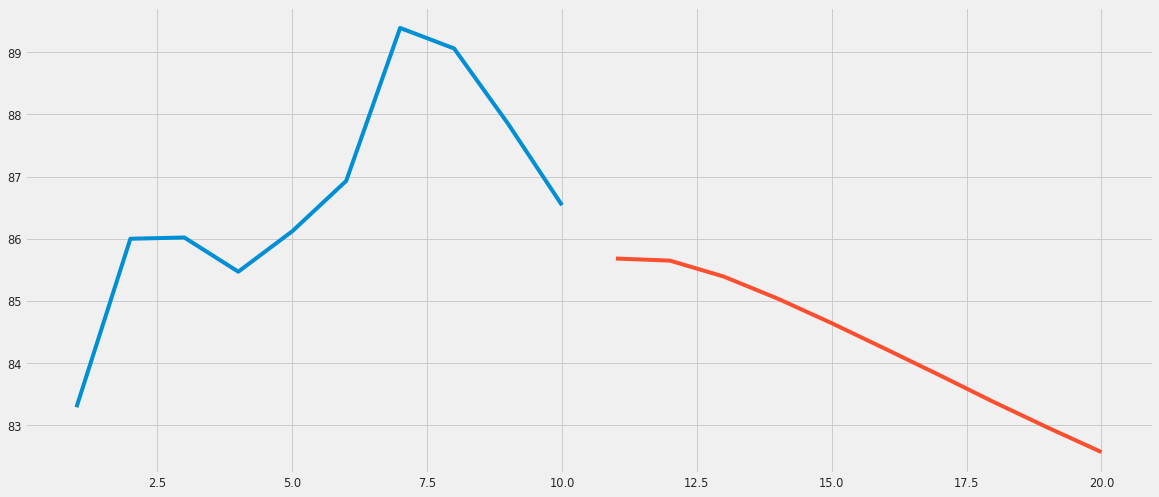

In [45]:
plt.plot(day_new,sc.inverse_transform(data_oil[9271:]))
plt.plot(day_pred,sc.inverse_transform(lst_output))